In [28]:
!pip install gymnasium
!pip install torch
!pip install matplotlib
!pip install wandb
!pip install python-dotenv

In [29]:
# Importing the required libraries
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os
from dotenv import load_dotenv
import numpy as np

In [30]:
# Check for IPython
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [31]:
# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Define the Transition named tuple and Replay Memory class
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [33]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [34]:
class WarehouseBot:
    def __init__(self, grid_size=(6, 6), render_mode="human"):
        # Define grid dimensions and observation/action space
        self.grid_size = grid_size
        self.action_space = gym.spaces.Discrete(4)  # Up, down, left, right
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(grid_size[0] * grid_size[1],), dtype=np.float32)

        # Define initial state
        self.state = np.zeros(self.grid_size).flatten()  # Flattened for compatibility with DQN
        self.done = False
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize positions
        self.bot_position = (0, 0)  # Starting position
        self.goal_position = (self.grid_size[0] - 1, self.grid_size[1] - 1)  # Goal position

    def reset(self):
        # Reset the grid and bot position
        self.state = np.zeros(self.grid_size).flatten()
        self.bot_position = (0, 0)
        self.update_state()
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            raise RuntimeError("Environment is done. Reset it before calling step().")

        # Move based on action
        x, y = self.bot_position
        if action == 0 and x > 0:             # Up
            x -= 1
        elif action == 1 and x < self.grid_size[0] - 1:  # Down
            x += 1
        elif action == 2 and y > 0:           # Left
            y -= 1
        elif action == 3 and y < self.grid_size[1] - 1:  # Right
            y += 1
        self.bot_position = (x, y)

        # Update state representation
        self.update_state()

        # Reward structure
        if self.bot_position == self.goal_position:
            reward = 10
            self.done = True
        else:
            reward = -0.1  # Small penalty for each step taken

        return self.state, reward, self.done, {}

    def update_state(self):
        # Reset grid and mark bot's current position
        self.state = np.zeros(self.grid_size).flatten()
        idx = self.bot_position[0] * self.grid_size[1] + self.bot_position[1]
        self.state[idx] = 1  # Set bot's position in the state

    def render(self):
        # Render the current grid
        grid = np.zeros(self.grid_size)
        grid[self.bot_position] = 1  # Mark bot's position
        print("Current Grid:")
        print(grid)

    def close(self):
        print("Closing the WarehouseBot environment.")

    def get_state(self):
        return self.state

In [35]:
# Initializing Environment
wb_env = WarehouseBot()

# Print the action space, observation space, and the initial state
print("Action Space:", wb_env.action_space.n)
print("Observation Space:", wb_env.observation_space.shape[0])
print("Initial State:", wb_env.reset())

Action Space: 4
Observation Space: 36
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
# DQN Agent
class DQNAgent:
    def __init__(self, env, input_dim, action_dim, memory_size=5000, batch_size=128, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500):
        self.env = env
        self.action_dim = action_dim
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.q_network = DQN(input_dim, action_dim).to(env.device)
        self.target_network = DQN(input_dim, action_dim).to(env.device)
        self.update_target_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.env.device)
            with torch.no_grad():
                return self.q_network(state).argmax().item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.env.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.env.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.env.device)
        next_states = torch.FloatTensor(next_states).to(self.env.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.env.device)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)
        self.optimizer.step()
        return loss.item()

    def update_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * np.exp(-1.0 / self.epsilon_decay))

In [37]:
# Load environment variables
load_dotenv()

# Initialize Wandb
use_wandb = os.environ.get("USE_WANDB", "false").lower() == "true"

class WandbLogger:
    def __init__(self, config, project, env):
        if use_wandb:
            wandb.init(project=project, config=config)
            self.config = wandb.config
        else:
            self.config = config

    def log(self, args):
        if use_wandb:
            wandb.log(args)
        else:
            print(args)


In [38]:
def training(env, agent, num_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C):
    max_steps = 500

    losses = []
    rewards = []
    epsilons = []
    rewards_per_episode = {}

    steps = 0

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state = env.reset()
        done = False
        episode_reward = 0
        total_loss = 0

        for t in range(max_steps):
            steps += 1
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            agent.update_experience(state, action, reward, next_state, done)
            loss = agent.train_step()
            if loss:
                total_loss += loss
            episode_reward += reward
            state = next_state

            if done:
                break

        agent.update_target_network() if episode % C == 0 else None
        agent.decay_epsilon()
        losses.append(total_loss / (t + 1))
        rewards.append(episode_reward)
        epsilons.append(agent.epsilon)
        rewards_per_episode[episode] = episode_reward

    return rewards, losses, rewards_per_episode, epsilons

In [50]:
# Run Training
num_episodes = 1000
batch_size = 128
epsilon = 1.0
gamma = 0.99
learning_rate = 1e-3
epsilon_decay = 0.01
C = 10

wb_env = WarehouseBot()
agent = DQNAgent(wb_env, wb_env.observation_space.shape[0], wb_env.action_space.n)

rewards, losses, rewards_per_episode, epsilons = training(wb_env, agent, num_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C)


Training Progress: 100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


In [51]:
def plot_rewards(rewards_per_ep, environment_type, epsilons=[]):
  episodes = np.array(list(rewards_per_ep.keys())).flatten()
  rewards = np.array(list(rewards_per_ep.values())).flatten()

  plt.figure(figsize=(10, 6))
  plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4)
  plt.title(f'Rewards per Episode {environment_type}')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.grid(True)
  plt.xticks(range(0, max(episodes)+1, max(1, len(episodes)//10)))

  plt.tight_layout()
  plt.show()

In [52]:
def plot_epsilon_decay(epsilon_values, environment_type):
  plt.title(f'Epsilon Decay {environment_type}')
  plt.plot(epsilon_values)
  plt.xlabel('Episode', fontsize=18)
  plt.ylabel('Epsilon Values', fontsize=18)
  plt.title('Epsilon Decay', fontsize=26)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.grid()
  plt.show()

In [53]:
def plot_rewards_per_episode(rewards_per_episode, environment_type, epsilons=None, window_size=10):
    episodes = list(rewards_per_episode.keys())
    rewards = list(rewards_per_episode.values())
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4, label='Rewards per Episode')
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episodes[:len(moving_avg)], moving_avg, color='r', label=f'Moving Avg (window={window_size})')

    plt.title(f'Rewards per Episode {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)

    # Include epsilon plot if provided
    if epsilons:
        ax2 = plt.gca().twinx()
        ax2.plot(episodes, epsilons, color='g', alpha=0.6, linestyle='--', label='Epsilon')
        ax2.set_ylabel('Epsilon', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()
    return plt

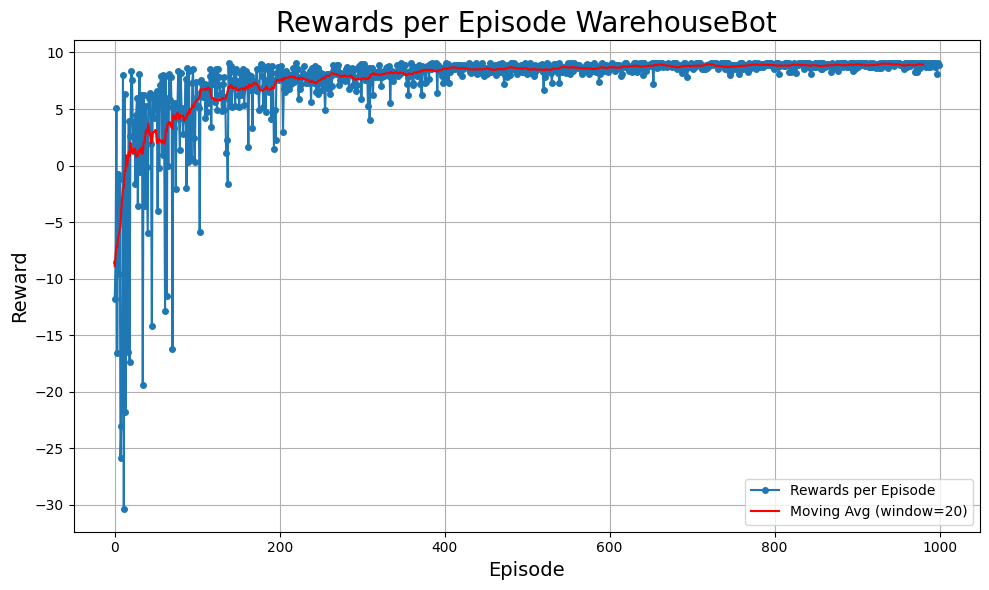

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [54]:
plot_rewards_per_episode(rewards_per_episode, 'WarehouseBot', window_size=20)

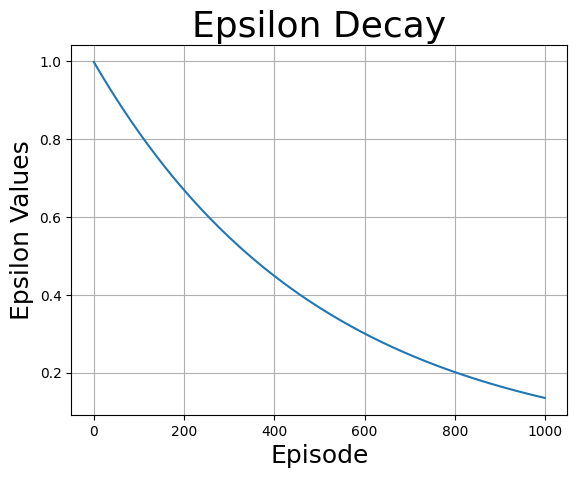

In [55]:
plot_epsilon_decay(epsilons, 'WarehouseBot')

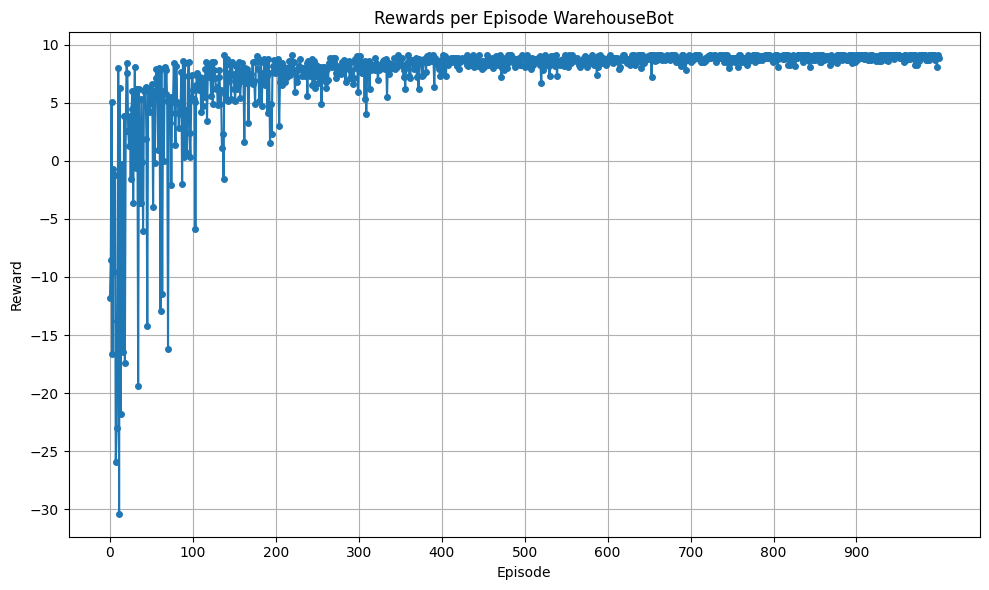

In [56]:
plot_rewards(rewards_per_episode, 'WarehouseBot')

In [73]:
torch.save(agent.q_network.state_dict(), "warehouseBot_dqn.pth")

In [74]:
from functools import total_ordering
import torch
import numpy as np
from tqdm import tqdm

def greedy_policy(agent, model, env, num_episodes):
    epsilon = 0  # Set epsilon to 0 for greedy policy
    rewards = []
    rewards_per_episode = {}
    epsilons = []

    model.eval()  # Set the model to evaluation mode
    total_rewards = 0

    for episode in tqdm(range(num_episodes), desc="Testing Progress"):
        state = env.reset()  # Reset the environment for each episode
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(env.device)  # Move state to the appropriate device
            with torch.no_grad():  # Disable gradient tracking
                q_values = model(state_tensor)  # Get action values from the model
                action = torch.argmax(q_values).item()  # Select action with highest Q-value

            next_state, reward, done, _ = env.step(action)  # Step in the environment
            episode_reward += reward  # Accumulate reward
            state = next_state  # Update state

        # Store rewards for this episode
        rewards.append(episode_reward)
        rewards_per_episode[episode] = episode_reward

    print(f"Rewards per episode: {rewards_per_episode}")  # Print rewards per episode
    rewards_per_episode_array = np.array(list(rewards_per_episode.values())).flatten()
    mean_rewards_per_episode = np.mean(rewards_per_episode_array)  # Calculate mean reward
    print(f"Mean rewards per episode: {mean_rewards_per_episode}")

    return mean_rewards_per_episode, rewards_per_episode, epsilons



In [75]:
num_test_episodes = 100
model = DQN(wb_env.observation_space.shape[0], wb_env.action_space.n)
model.load_state_dict(torch.load("warehouseBot_dqn.pth"))
mean_rewards, rewards_per_episode, epsilons = greedy_policy(agent, model, wb_env, num_test_episodes)

<ipython-input-75-d507beb1ab90>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("warehouseBot_dqn.pth"))
Testing Progress: 100%|██████████|

Rewards per episode: {0: 9.1, 1: 9.1, 2: 9.1, 3: 9.1, 4: 9.1, 5: 9.1, 6: 9.1, 7: 9.1, 8: 9.1, 9: 9.1, 10: 9.1, 11: 9.1, 12: 9.1, 13: 9.1, 14: 9.1, 15: 9.1, 16: 9.1, 17: 9.1, 18: 9.1, 19: 9.1, 20: 9.1, 21: 9.1, 22: 9.1, 23: 9.1, 24: 9.1, 25: 9.1, 26: 9.1, 27: 9.1, 28: 9.1, 29: 9.1, 30: 9.1, 31: 9.1, 32: 9.1, 33: 9.1, 34: 9.1, 35: 9.1, 36: 9.1, 37: 9.1, 38: 9.1, 39: 9.1, 40: 9.1, 41: 9.1, 42: 9.1, 43: 9.1, 44: 9.1, 45: 9.1, 46: 9.1, 47: 9.1, 48: 9.1, 49: 9.1, 50: 9.1, 51: 9.1, 52: 9.1, 53: 9.1, 54: 9.1, 55: 9.1, 56: 9.1, 57: 9.1, 58: 9.1, 59: 9.1, 60: 9.1, 61: 9.1, 62: 9.1, 63: 9.1, 64: 9.1, 65: 9.1, 66: 9.1, 67: 9.1, 68: 9.1, 69: 9.1, 70: 9.1, 71: 9.1, 72: 9.1, 73: 9.1, 74: 9.1, 75: 9.1, 76: 9.1, 77: 9.1, 78: 9.1, 79: 9.1, 80: 9.1, 81: 9.1, 82: 9.1, 83: 9.1, 84: 9.1, 85: 9.1, 86: 9.1, 87: 9.1, 88: 9.1, 89: 9.1, 90: 9.1, 91: 9.1, 92: 9.1, 93: 9.1, 94: 9.1, 95: 9.1, 96: 9.1, 97: 9.1, 98: 9.1, 99: 9.1}
Mean rewards per episode: 9.1


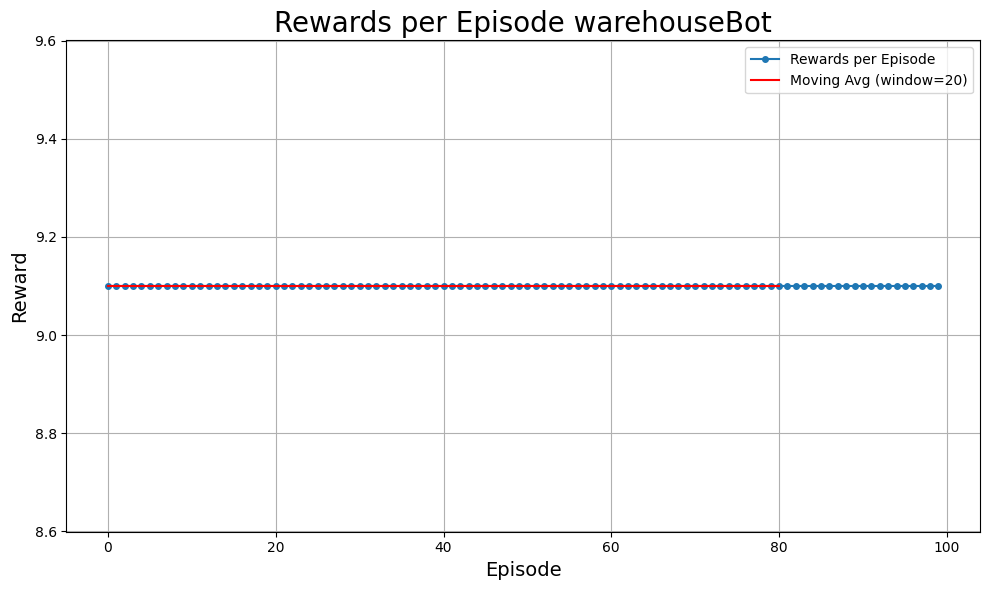

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [76]:
plot_rewards_per_episode(rewards_per_episode, 'warehouseBot', window_size=20)